Transition path analysis for alanine-dipeptide
==============================================

This notebook shows usage examples for transition path-analysis using the tpt (transition path theory) members of the emma.msm.analysis package. 

A given MSM, estimated from alanine-dipeptide simulation data at lagtime $\tau=6ps$, is used as an example to carry out analysis.

The necessary inputs are:

1. the transition matrix, 'T.dat'
2. the centers of the $(\phi, \psi)$ dihedral angle space regular grid discretization, 'grid_centers20x20.dat'
3. the largest set of connected microstates, 'lcc.dat'

<!-- Auxiliary functions in 'plotting.py' are used to generate figures of the estimated quantities. -->

In [1]:
import pyemma
pyemma.__version__

u'1.2+376.ge5a81e7'

This notebook has been tested for version 1.2.2. If you are using a different version some adaptations may be required.

In [2]:
# general imports
import util
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
# PyEMMA imports
import pyemma.msm as msm
import pyemma.plots as mpl
# Additional helper functions
import plotting

Populating the interactive namespace from numpy and matplotlib


Read the already created Markov model for alanine dipeptide

In [3]:
# load data
indir = './'
T = msm.io.read_matrix(indir+'/T.dat')
T.shape

(252, 252)

Read the the largest connected set and the cluster centers. Choose only those cluster centers, which are connected.
- describe mapping

In [4]:
lcc = msm.io.read_matrix(indir+'/lcc.dat', dtype=int)
centers = msm.io.read_matrix(indir+'/grid_centers20x20.dat')[lcc , :]
lccmap=util.MapToConnectedStateLabels(lcc)

First we calculate an MSM from the transition matrix and store it as 'model'

In [5]:
model = msm.markov_model(T)

Committors between two metastable states
----------------
The two metastable sets $C_5$ and $C_7^{ax}$ in the dihedral angle plane are used to carry out the fingerprint analysis.

The $C_5$-conformation can be found with high probability in equilibrium while the $C_7^{ax}$ conformation is only rarely visited.

In [6]:
C5 = [20, 40, 36, 37, 38, 39, 56, 57, 58, 59]
C7ax = [253, 254]


C5_mapped = lccmap.map(C5)
C7ax_mapped = lccmap.map(C7ax)

First we calculate the committors from the $C_5$ to the $C_7^{ax}$ set.

In [7]:
u = model.committor_forward(C5_mapped, C7ax_mapped)
w = model.committor_backward(C5_mapped, C7ax_mapped)

Because a direct plot of the committor would not respect our grid centers, we project the calculated values back into the $(\phi, \psi)$ dihedral angle space. This is implemented in the plotting module, which lies next to this notebook.

/storage/mi/nplattner/miniconda/envs/PyE_1.2.2/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/storage/mi/nplattner/miniconda/envs/PyE_1.2.2/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


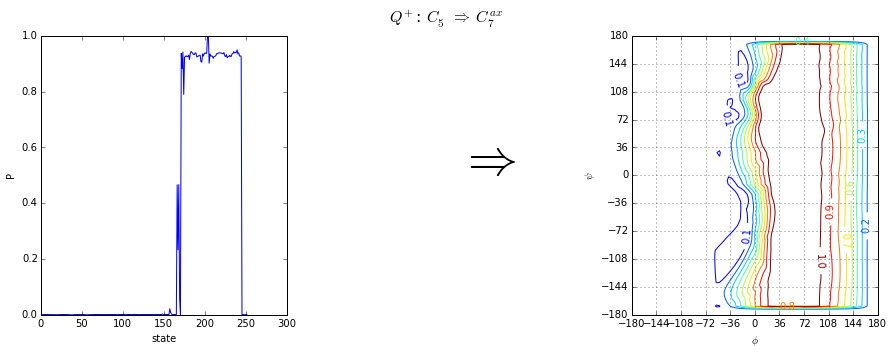

In [8]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
fig.suptitle("$Q^+$: %s $ \Rightarrow $ %s" % ('$C_5$', '$C_7^{ax}$'), fontsize=16)
ax = axes[0]

ax.plot(u)
ax.set_xlabel('state')
ax.set_ylabel('P')

ax = axes[1]
ax.text(0, 0, "$\Rightarrow$", {'fontsize': 50})
ax.axis('scaled')
ax.axis('off')

plotting.committor(centers, u, levels=np.linspace(0.0, 1.0, 10), ax=axes[2])

plt.show()

Plot forward and backward committor

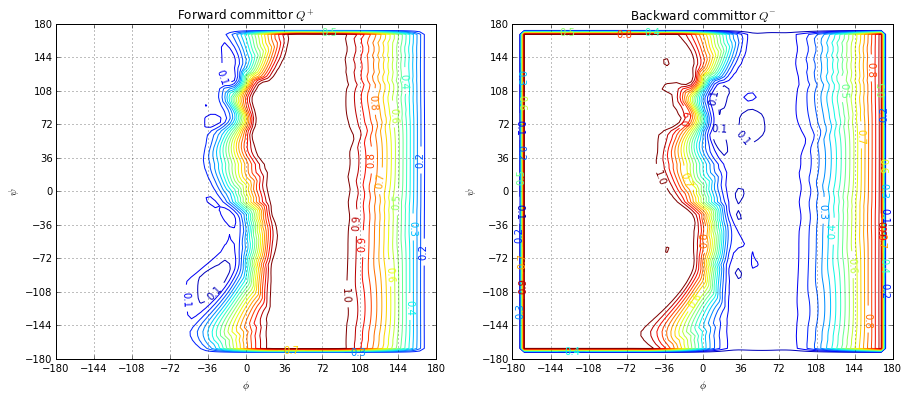

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].set_title("Forward committor $Q^+$")
ax[1].set_title("Backward committor $Q^-$")
ax[0].grid()
ax[1].grid()
plotting.committor(centers, u, levels=np.linspace(0.0, 1.0, 20), ax=ax[0])
plotting.committor(centers, w, levels=np.linspace(0.0, 1.0, 20), ax=ax[1])

plt.show()

Now we can use the committors for the TPT calculation. NOTE: this is optional, if they are not given, they will be calculated in the TPT class on initialization. You may also give the stationary distribution, if you have already calculated it.

In [10]:
tpt_c5_c7ax = msm.tpt(model, C5_mapped, C7ax_mapped)

# access some quantities of the TPT object
print "Total flux:", tpt_c5_c7ax.total_flux
print "Rate:", tpt_c5_c7ax.rate

Total flux: 0.000129171848765
Rate: 0.000133818433556


Transition pathways between two sets coarse grained over metastable states
-------
Here we define a set of 6 metastable states, including the two above and calculate the transition network between thes two sets defined above. A transition network could in principle also be plotted in the microstate space, however this would not be very helpful for understanding the process.

In [11]:
P2 = [116, 117, 118, 119, 136, 137, 138, 139]
aP = [25, 26, 27, 45, 46, 47]
aR = [105, 106, 107, 125, 126, 127]
aL = [242, 244]

metastableSets = [C5, P2, aP, aR, C7ax, aL]
names = ['C5', 'P2', 'aP', 'aR', 'C7ax', 'aL']

# apply map function to map microstates to connected microstates
X = map(lccmap.map, metastableSets)
# combine set names with their values
X_named = zip(names, X)

Now we calculate the coarse grained flux between these sets.

In [12]:
cg, cgflux = tpt_c5_c7ax.coarse_grain(metastableSets)

For the network plot we calculate the average coordinates of these centers. This is not strictly necessary, since the plotting routine can also place the states automatically.

In [13]:
# calculate centers of metastable states
ind = 0
avgcen = np.zeros((len(metastableSets),2))
for i in range(len(metastableSets)):
    for num in (X[i]):
        avgcen[ind] += centers[num]/len(X[i])
    ind += 1

Network plot with pyemma plotting tools:

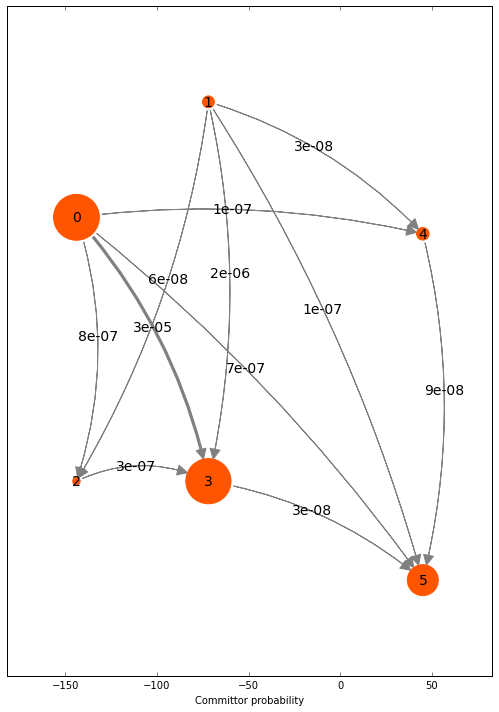

In [14]:
Net_plot = mpl.plot_flux(cgflux,pos=avgcen,minflux=1e-8)